In [1]:
import librosa
import os
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import random
%matplotlib inline
import IPython.display as ipd
import librosa, librosa.display
import pandas as pd

import numpy as np
import keras
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Embedding,CuDNNLSTM,LSTM,GlobalAveragePooling2D, TimeDistributed, Input, Conv2D, Flatten, Dense, MaxPooling2D,AveragePooling2D, Dropout, UpSampling2D, concatenate, Cropping2D,LeakyReLU, Reshape, BatchNormalization
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.optimizers import SGD, Adam, Nadam
from keras import regularizers
import keras.callbacks
from keras import backend as K
from keras.models import Sequential

import os
import pickle
import sklearn
import itertools
import math
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder


Using TensorFlow backend.


In [24]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

FailedPreconditionError: Failed to allocate scratch buffer for device 0

In [2]:
# 39 + 1 PHONEMES 
PHONEMES = ['aa', 'ae', 'ah', 'aw', 'ay' ,'b', 'ch', 'd', 'dh', 'dx', 'eh', 'er', 'ey', 'f', 'g',
 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p', 'q', 'r', 's', 'sh',
 'sil' ,'t', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z']

In [3]:
# 61 PHONEMES
PHONEMES = ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 
            'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh', 'k', 'kcl', 
            'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pau', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 
            'ux', 'v', 'w', 'y', 'z', 'zh']
PHONEMES.sort()


## Tools for Training Models

In [4]:
class Logger(keras.callbacks.Callback):

    def __init__(self):
        self.losses = []
        self.x = []
        self.accuracies = []
        self.val_losses = []
        self.val_acc = []
        self.i = 0
        self.best_model = None
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.x.append(self.i)
        self.plot()
    
    def plot(self):
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        N = len(self.losses)
        
        ax1.set_yscale('log')
        ax1.plot(range(0, N), self.losses, label="loss")
        ax1.plot(range(0, N), self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(range(0, N), self.accuracies, label="accuracy")
        ax2.plot(range(0, N), self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

## LSTM for phoneme predictions

In [5]:
PREDICTION_LOCATION = "./PREDICTIONS/"

## Seq-to-Seq
taken from https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

In [14]:
class BatchCreator():
    def __init__(self,context_size=10):
        self.le = LabelEncoder()
        y = self.le.fit_transform(PHONEMES)
        y = y.reshape(-1,1)
        self.ohe = OneHotEncoder()
        self.ohe.fit_transform(y)
        self.step = 1
        self.target_size = 10
        self.context_size = context_size
            
    def create_batch(self, batch_size, dataset = r"TRAIN/"):
        '''
        returns a batch of size batch_size from dataset. Default dataset is "TRAIN/". For creating batches
        for a test use "TEST/"
        '''
        x_data = []
        y_data = []
        y_dec_data = []
        for i in range(batch_size):
            # generating a window for #batchsize files of 1s or 100 sliding windows
            file = random.choice([x for x in os.listdir(r"PREDICTIONS/" + dataset) if os.path.isfile(os.path.join(r"PREDICTIONS/" + dataset, x))])
            predictions = np.load(r"PREDICTIONS/" + dataset + file)
            #idx = random.randint(0, len(predictions) - (context_size))
            if len(predictions) < self.context_size +self.step: 
                idx = 0
                #print(len(predictions))
                #print(context_size-len(predictions))
                pad = np.zeros((self.context_size-len(predictions), 1, 61))
                x_data.append(np.concatenate((predictions, pad)))
            else:
                idx = random.randint(0, len(predictions)-(self.context_size+self.step))
                # x_data
                x_data.append(np.array(predictions[idx:idx+self.context_size]))
            
            # y data
            
            num_lines = sum(1 for line in open(r"PHN_converted_2/" + dataset + file.split('.')[0] + ".txt"))
       
            with open(r"PHN_converted_2/" + dataset +file.split('.')[0] + ".txt") as fp:
                y = []
                y_dec = []
                if len(predictions) < self.context_size  + self.step: 
                    for j in range(self.context_size):
                        if j >= idx and j < len(predictions):
                            y.append(fp[j].split("\n")[0])
                        else:
                            y.append("h#")
                            
                        if j+step >= idx and j+self.step < len(predictions):
                            y_dec.append(fp[j+self.step].split("\n")[0])
                        else:
                            y_dec.append("h#")
                else:
                    for i, phone in enumerate(fp):
                      
                        if i >= idx and i < idx + self.target_size:
                            y.append(phone.split("\n")[0])
                        if i >= idx+self.step and i < idx + self.target_size + self.step: 
                            y_dec.append(phone.split("\n")[0])
                            
                
    
                y = np.asarray(self.le.transform(y)).reshape(-1,1)        
                y = self.ohe.transform(y).toarray()
                y_data.append(y)
                y_dec = np.asarray(self.le.transform(y_dec)).reshape(-1,1)        
                y_dec = self.ohe.transform(y_dec).toarray()
                y_dec_data.append(y_dec) 
                
        
        X = np.asarray(x_data).reshape(batch_size, self.context_size, 61)
        y = np.asarray(y_data).reshape(batch_size,self.target_size, 61)
        y_dec = np.asarray(y_dec_data).reshape(batch_size,self.target_size, 61)
        
        return [X, y], y_dec
        
        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size=batch_size)

In [15]:
batch_creator = BatchCreator()


/scratch/jvermazeren/ASR/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
[x,y],z = batch_creator.create_batch(1, dataset=r"TEST/")

In [17]:
print("x:", [PHONEMES[x] for x in np.argmax(x[0], axis=1)])
print("y:", [PHONEMES[x] for x in np.argmax(y[0], axis=1)])
print("z:", [PHONEMES[x] for x in np.argmax(z[0], axis=1)])

x: ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'l']
y: ['q', 'q', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'l', 'l']
z: ['q', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'l', 'l', 'l']


In [18]:
def define_models(n_input, n_output, n_units,n_features = 61):
   
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = Embedding(61, n_units)(encoder_inputs)
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder = Embedding(61, n_units)(decoder_inputs)
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    # return all models
    return model, encoder_model, decoder_model

In [19]:
# function to train a model
def train_model(model, training_params):
    
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    logger = training_params['logger']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
#     training_dataset = training_params['training_dataset']
#    validation_dataset = training_params['validation_dataset']
    validation_size = training_params['validation_size']
    validation_steps = training_params['validation_steps']
    context_size = training_params['context_size']
    # batch generator 
    train_batch_creator = BatchCreator(context_size=context_size)
    test_batch_creator = BatchCreator(context_size=context_size)
    generator = train_batch_creator.get_generator(batch_size)
    validation_generator = test_batch_creator.get_generator(validation_size)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit_generator(generator=generator, callbacks=[logger], steps_per_epoch=steps_per_epoch, 
                                  epochs=epochs,use_multiprocessing = False,
                                  validation_data=validation_generator,validation_steps=validation_steps)
    
#     train.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=50, validation_data= ([encoder_input_data_val,decoder_input_data_val],decoder_target_data_val ),batch_size=64)
    return history

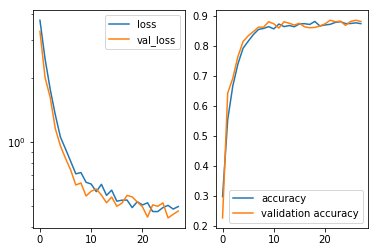

Epoch 29/100
 8/10 [=======================>......] - ETA: 4s - loss: 0.4556 - acc: 0.8850

KeyboardInterrupt: 

In [20]:
model_name = 'lstm'

n_features = 61

model, infenc, infdec = define_models(n_features,n_features,128,n_features)


training_params = {}
training_params['learning_rate'] = 0.01
training_params['batch_size'] = 64 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 10
training_params['epochs'] = 100
# training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.9, nesterov=True)
training_params['optimizer'] = Nadam(lr=training_params['learning_rate'])
training_params['loss'] = ['categorical_crossentropy']
training_params['metrics'] = ['accuracy']
training_params['encoder_model'] = infenc
training_params['decoder_model'] = infdec
training_params['validation_size'] = 100
training_params['validation_steps'] = 1
training_params['context_size'] =10
# training_params['training_dataset'] = train_data
# training_params['validation_dataset'] = validation_data
training_params['logger'] = Logger()

model, infenc, infdec = define_models(n_features, n_features, n_units = 256)
history = train_model(model, training_params)

In [29]:
test = np.zeros((1,61))
test[0,31]= 1
print(test)
# print(model.predict(test))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return np.array(output)

In [22]:
total, correct,correct_original = 1000, 0, 0

size = 10
Batch_Creator = BatchCreator(context_size =10)
[X_test,y_test], _ = Batch_Creator.create_batch(total)
print(y_test.shape)
for j in range(total):
    target = predict_sequence(infenc, infdec, np.expand_dims(X_test[j], axis=0), size, n_features)
    # x_test = [PHONEMES[x] for x in np.argmax(X_test[i], axis=1)])
    
    y_hat = [PHONEMES[x] for x in np.argmax(target, axis=1)]
    y=[PHONEMES[x] for x in np.argmax(y_test[j], axis=1)]
    x = [PHONEMES[x] for x in np.argmax(X_test[j], axis=1)]
    
    for i in range(size):
        if np.array_equal(y[i], y_hat[i]):
            correct += 1
        if np.array_equal(x[i],y[i]):
            
            correct_original +=1
    
    print("Input:", [PHONEMES[x] for x in np.argmax(X_test[j], axis=1)])
    print("Predicted: ", y_hat)
    print("True: ", y)
    print('\n')
print('Accuracy: %.2f%%' % (float(correct)/float(total*size)*100.0))
print('Original Accuracy: %.2f%%' % (float(correct_original)/float(total*size)*100.0))
print('Input = ',  [PHONEMES[x] for x in np.argmax(X_test[j], axis=1)])
print('Predicted = '  , y_hat)
print('True = ', y)

/scratch/jvermazeren/ASR/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1000, 10, 61)
Input: ['pau', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['l', 'l', 'l', 'l', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl']
Predicted:  ['l', 'l', 'l', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl']
True:  ['ah', 'ah', 'ah', 'ah', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl']


Input: ['ix', 'kcl', 'kcl', 'kcl', 'kcl', 'kcl', 'k', 'k', 'k', 'k']
Predicted:  ['kcl', 'kcl', 'kcl', 'kcl', 'k', 'k', 'k', 'k', 'k', 'aa']
True:  ['ux', 'ux', 'kcl', 'kcl', 'kcl', 'k', 'k', 'k', 'k', 'ix']


Input: ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'l', 'l', 'l']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['ao', 'ao', 'ao', 'ao', 'ao', 'l', 'l', 'l', 'l', 'l']


Input: ['iy', 'dx', 'dx', 'nx', 'nx', 'ax', 'ax', 'ax', 'ax', 'ax']
Predicted:  ['dx', 'dx', 'dx', 'dx', 'ax', 'ax', 'ax', 'ax', 'l', 'l']
True:  [

Input: ['epi', 'epi', 'dcl', 'dcl', 'd', 'jh', 'jh', 'jh', 'ah', 'ah']
Predicted:  ['dcl', 'dcl', 'dcl', 'd', 'd', 'aa', 'aa', 'aa', 'aa', 'aa']
True:  ['dcl', 'dcl', 'dcl', 'dcl', 'jh', 'jh', 'jh', 'jh', 'eh', 'eh']


Input: ['q', 'q', 'q', 'q', 'q', 'aa', 'aa', 'aa', 'aa', 'aa']
Predicted:  ['q', 'q', 'q', 'q', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']
True:  ['q', 'q', 'q', 'q', 'q', 'aw', 'aw', 'aw', 'aw', 'aw']


Input: ['b', 'b', 'ow', 'ow', 'ow', 'ow', 'ow', 'ah', 'ah', 'ah']
Predicted:  ['eh', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow']
True:  ['b', 'r', 'r', 'r', 'r', 'ah', 'ah', 'ah', 'ah', 'ah']


Input: ['m', 'm', 'm', 'iy', 'iy', 'iy', 'iy', 'iy', 'ng', 'dx']
Predicted:  ['iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'dcl', 'dcl', 'd']
True:  ['m', 'm', 'm', 'iy', 'iy', 'iy', 'iy', 'iy', 'dx', 'dx']


Input: ['r', 'el', 'el', 'ao', 'ao', 'ao', 'el', 'el', 'l', 'l']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'a

Input: ['hh', 'hh', 'hh', 'hh', 'hh', 'uh', 'ux', 'ux', 'ux', 'ux']
Predicted:  ['hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'ix', 'ux', 'ux', 'ux']
True:  ['h#', 'hh', 'hh', 'hh', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux']


Input: ['n', 's', 's', 'z', 'z', 'z', 'z', 'hh', 'hh', 'hh']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['n', 's', 's', 's', 's', 's', 's', 's', 's', 's']


Input: ['axr', 'axr', 'axr', 'axr', 'hh', 'hh', 'hh', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['axr', 'axr', 'axr', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['pau', 'pau', 'pau', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['n', 'n', 'th', 'th', 'th', 'th', 'th', 't', 'th', 'th']
Predicted:  ['tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 't', 't', 't', 't']
True:  ['tcl', 'tcl', 'tcl', 'tcl

Input: ['axr', 'axr', 'axr', 'axr', 'axr', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl']
Predicted:  ['axr', 'axr', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'b']
True:  ['axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'bcl', 'bcl', 'bcl', 'bcl']


Input: ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'sh']
Predicted:  ['ao', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'r']
True:  ['aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']


Input: ['aw', 'aw', 'aw', 'aw', 'aw', 'ax', 'ax', 'ax', 'ax', 'ax']
Predicted:  ['ah', 'ax', 'ax', 'ax', 'ax', 'ax', 'ax', 'm', 'm', 'm']
True:  ['er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er']


Input: ['z', 'z', 'zh', 'zh', 'dcl', 'dcl', 'dcl', 'gcl', 'jh', 'jh']
Predicted:  ['s', 's', 'dcl', 'dcl', 'dcl', 'dcl', 'dcl', 'jh', 'jh', 'ix']
True:  ['z', 'z', 'z', 'dcl', 'dcl', 'dcl', 'dcl', 'jh', 'jh', 'jh']


Input: ['bcl', 'bcl', 'bcl', 'bcl', 'b', 'b', 'ey', 'ey', 'ey', 'ey']
Predicted:  ['v', 'v', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey

Input: ['em', 'em', 'em', 'w', 'w', 'w', 'w', 'w', 'ao', 'ao']
Predicted:  ['w', 'w', 'w', 'w', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']
True:  ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'ah', 'ah', 'ah']


Input: ['tcl', 'tcl', 'tcl', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
Predicted:  ['tcl', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
True:  ['kcl', 'kcl', 'kcl', 't', 't', 't', 't', 't', 'h#', 'h#']


Input: ['iy', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'el', 'el', 'l']
Predicted:  ['ih', 'ix', 'ix', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'l', 'l', 'l', 'l']


Input: ['jh', 'gcl', 'gcl', 'gcl', 'g', 'g', 'g', 'aw', 'aw', 'aw']
Predicted:  ['gcl', 'gcl', 'g', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']
True:  ['gcl', 'gcl', 'g', 'g', 'g', 'g', 'g', 'aw', 'aw', 'aw']


Input: ['er', 'er', 'axr', 'axr', 'axr', 'ix', 'z', 'z', 'z', 'z']
Predicted:  ['ix', 'ix', 'ix', 'ix', 'z', 'z', 'z', 'z', 'z', 'z']
True:  ['r', 'r', 'r', 'r', 'r', 'r', 'r', 's', 's', 's']


Input:

Input: ['iy', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv']
Predicted:  ['hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv', 'hv']
True:  ['iy', 'iy', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh']


Input: ['z', 'z', 'z', 'z', 'em', 'em', 'ax', 'ax', 'ax', 'nx']
Predicted:  ['z', 'z', 'dh', 'ax', 'ix', 'ix', 'ix', 'm', 'm', 'm']
True:  ['z', 'z', 'z', 'z', 'ax', 'ax', 'ax', 'ax', 'ax', 'ax']


Input: ['el', 'el', 'el', 'el', 'el', 'el', 'aa', 'ay', 'ay', 'ay']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'er']
True:  ['el', 'el', 'el', 'el', 'el', 'el', 'ay', 'ay', 'ay', 'ay']


Input: ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['jh', 'jh', 'jh', 'er', 'er', 'er', 'er', 'er', 'er', 'er']
Predicted:  ['er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er']
True:  ['jh', 'jh', 'er', 'er', 'er',

Input: ['s', 's', 's', 's', 'ax', 'ax', 'ax', 'ax', 'v', 'v']
Predicted:  ['v', 'v', 'ax', 'ax', 'ax', 'ax', 'ax', 'bcl', 'bcl', 'pcl']
True:  ['s', 's', 's', 'ax', 'ax', 'ax', 'ax', 'ax', 'ax', 'v']


Input: ['l', 'l', 'l', 'l', 'l', 'm', 'm', 'm', 'm', 'm']
Predicted:  ['l', 'l', 'l', 'l', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['l', 'l', 'l', 'l', 'n', 'n', 'n', 'n', 'n', 'n']


Input: ['ay', 'ay', 'ay', 'ay', 'ay', 'ey', 'ey', 'ey', 'ey', 'ey']
Predicted:  ['ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey']
True:  ['ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay']


Input: ['f', 'f', 'f', 'f', 'f', 'uh', 'uh', 'uh', 'uh', 'uh']
Predicted:  ['f', 'w', 'r', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['f', 'f', 'f', 'f', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah']


Input: ['ch', 'jh', 'jh', 'ch', 'ch', 'ch', 'ux', 'ux', 'ih', 'ih']
Predicted:  ['t', 't', 't', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih']
True:  ['jh', 'jh', 'jh', 'jh', 'jh', 'jh', 'ih', 'ih', 'ih', 'ih']


Input:

Input: ['ih', 'ih', 'ih', 'ih', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr']
Predicted:  ['axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr']
True:  ['axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'h#']


Input: ['v', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']
Predicted:  ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']
True:  ['axr', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']


Input: ['ah', 'ah', 'ah', 'ah', 'ow', 'uh', 'uh', 'pcl', 'pcl', 'pcl']
Predicted:  ['ah', 'ah', 'ah', 'ah', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl', 'pcl']
True:  ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'pcl', 'pcl', 'pcl', 'pcl']


Input: ['ax', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'b', 'b']
Predicted:  ['bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'b', 'b', 'er']
True:  ['ax', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'bcl', 'b']


Input: ['ix', 'ix', 'v', 'v', 'f', 'f', 'f', 'f', 'f', 'f']
Predicted:  ['v', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']
True: 

Input: ['epi', 'epi', 'epi', 'epi', 'm', 'm', 'm', 'm', 'm', 'm']
Predicted:  ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['s', 's', 's', 'm', 'm', 'm', 'm', 'm', 'm', 'iy']


Input: ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'sh', 'sh', 'sh', 'sh']
Predicted:  ['ao', 'ey', 'ay', 'ay', 'sh', 'sh', 'sh', 'sh', 'sh', 'sh']
True:  ['ao', 'ao', 'ao', 'ao', 'ao', 'ao', 'sh', 'sh', 'sh', 'sh']


Input: ['y', 'eh', 'eh', 'eh', 'eh', 'eh', 'ah', 's', 's', 's']
Predicted:  ['eh', 'ix', 'ix', 'ix', 'ix', 's', 's', 's', 's', 's']
True:  ['eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 's', 's', 's']


Input: ['y', 'y', 'y', 'y', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux']
Predicted:  ['ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux']
True:  ['y', 'y', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux', 'ux']


Input: ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']


Input: ['h#', 

Input: ['k', 'k', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw']
Predicted:  ['aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'ax', 'l']
True:  ['k', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw']


Input: ['pau', 'pau', 'th', 'th', 'pau', 'pau', 'd', 'd', 'd', 'ow']
Predicted:  ['dcl', 'dcl', 'dcl', 'dcl', 'd', 'd', 'd', 'r', 'r', 'r']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'd', 'd', 'ow']


Input: ['aw', 'aa', 'aa', 'aa', 'f', 'f', 'f', 'f', 'f', 'f']
Predicted:  ['ey', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']
True:  ['ao', 'ao', 'ao', 'f', 'f', 'f', 'f', 'f', 'f', 'f']


Input: ['p', 'p', 'p', 'p', 'p', 'l', 'l', 'l', 'l', 'l']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['p', 'p', 'p', 'p', 'l', 'l', 'l', 'l', 'ey', 'ey']


Input: ['s', 's', 's', 'tcl', 'kcl', 't', 't', 't', 't', 'ux']
Predicted:  ['tcl', 'tcl', 'tcl', 'tcl', 't', 't', 't', 't', 't', 'ux']
True:  ['s', 's', 's', 'tcl', 'tcl', 'tcl', 't', 't', 't', 'ih']


Input: ['dc

Input: ['sh', 'sh', 'sh', 'ch', 'ch', 'ch', 'zh', 'zh', 'zh', 'th']
Predicted:  ['sh', 'sh', 'sh', 'sh', 'sh', 'sh', 'sh', 'sh', 'sh', 'sh']
True:  ['s', 's', 's', 's', 's', 's', 's', 'f', 'f', 'f']


Input: ['hv', 'hv', 'hv', 'hv', 'hv', 'ay', 'ay', 'ah', 'ah', 'ah']
Predicted:  ['hv', 'hv', 'hv', 'ae', 'ae', 'ae', 'aa', 'aa', 'aa', 'aa']
True:  ['hv', 'hv', 'hv', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah']


Input: ['s', 'th', 'th', 'th', 'th', 'th', 'th', 'dh', 'ux', 'ux']
Predicted:  ['s', 'th', 'th', 'th', 'th', 'ix', 'ix', 'ix', 'ix', 'ix']
True:  ['s', 's', 's', 's', 's', 's', 's', 'ix', 'ix', 'ix']


Input: ['s', 's', 's', 's', 'ch', 'ch', 'ch', 'ch', 'ch', 'iy']
Predicted:  ['tcl', 'tcl', 'tcl', 't', 't', 't', 't', 't', 't', 'ux']
True:  ['s', 's', 'dcl', 'dcl', 'dcl', 'd', 'd', 'd', 'd', 'd']


Input: ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', '

Input: ['pcl', 'pcl', 'm', 'm', 'm', 'm', 'iy', 'ix', 'ix', 'ix']
Predicted:  ['m', 'm', 'm', 'm', 'm', 'iy', 'ix', 'ix', 'ix', 'ix']
True:  ['epi', 'epi', 'epi', 'm', 'm', 'ix', 'ix', 'ix', 'ix', 'ix']


Input: ['pcl', 'pcl', 'pcl', 'pcl', 'th', 'th', 'th', 'th', 'th', 'th']
Predicted:  ['th', 'th', 'th', 'th', 'th', 'th', 'th', 'th', 'th', 'th']
True:  ['tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'h#', 'h#']


Input: ['aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']
Predicted:  ['aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']
True:  ['aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']


Input: ['m', 'm', 'ix', 'ix', 'iy', 'iy', 'ih', 'ng', 'ng', 'gcl']
Predicted:  ['ix', 'ix', 'ix', 'ix', 'ix', 'ng', 'ng', 'ng', 'ng', 'ng']
True:  ['m', 'm', 'ix', 'ix', 'ix', 'ix', 'dcl', 'dcl', 'dcl', 'dcl']


Input: ['ow', 'ow', 'ow', 'ow', 'ow', 'uw', 'uw', 'm', 'm', 'm']
Predicted:  ['ix', 'ix', 'ix', 'ix', 'ix', 'm', 'm', 'm', 'm', 'm']
True:  ['m', 'm'

Input: ['dcl', 'epi', 'epi', 'epi', 's', 's', 's', 's', 's', 's']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['gcl', 'gcl', 'gcl', 'z', 'z', 'z', 'z', 'z', 'z', 'z']


Input: ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
Predicted:  ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['m', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']


Input: ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'aw', 'aw', 'aw', 'aw']
Predicted:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'tcl']
True:  ['aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw']


Input: ['iy', 'iy', 'iy', 'iy', 'dx', 'dx', 'dx', 'dx', 'dx', 'iy']
Predicted:  ['iy', 'iy', 'dx', 'dx', 'dx', 'dx', 'dx', 'dx', 'ix', 'ix']
True:  ['iy', 'iy', 'iy', 'iy', 'iy', 'dx', 'dx', 'ix', 'ix', 'ix']


Input: ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
Predicted:  ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
True:  ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']


Input: ['aa', 'aa', 

Input: ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w']
Predicted:  ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'aa', 'aa', 'aa']
True:  ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w']


Input: ['ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'gcl', 'gcl', 'g', 'g']
Predicted:  ['ey', 'ix', 'ix', 'gcl', 'gcl', 'gcl', 'gcl', 'g', 'g', 'g']
True:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'gcl', 'gcl', 'gcl', 'gcl']


Input: ['oy', 'oy', 'ey', 'ey', 's', 's', 's', 's', 's', 's']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['oy', 'oy', 'oy', 'oy', 's', 's', 's', 's', 's', 's']


Input: ['h#', 'pau', 'pau', 'pau', 'pau', 'pau', 'pau', 'pau', 'pau', 'pau']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['q', 'q', 'q', 'q', 'q', 'q', 'q', 'ih', 'ih', 'ih']
Predicted:  ['q', 'q', 'q', 'q', 'q', 'ih', 'ih', 'ih', 'ih', 'ih']
True:  ['q', 'q', 'q', 'q', 'q', 'q', 'ix', 'ix', 'ix', 'ix']


Input: ['ux', 'ux', 'ux', 'l', 'n', 'n', 'n', 'm', 'hv', 'hv']
Predicted:  ['r', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['uw', 'uw', 'uw', 'uw', 'uw', 'uw', 'uw', 'hv', 'hv', 'hv']


Input: ['r', 'r', 'r', 'r', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy']
Predicted:  ['r', 'r', 'r', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy']
True:  ['r', 'r', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih']


Input: ['ae', 'gcl', 'gcl', 'gcl', 'g', 'g', 'g', 'l', 'l', 'l']
Predicted:  ['gcl', 'gcl', 'gcl', 'g', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['ae', 'ae', 'gcl', 'gcl', 'gcl', 'gcl', 'l', 'l', 'l', 'l']


Input: ['ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'dx']
Predicted:  ['ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'dx', 'dx']
True:  ['ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey', 'ey']


Input: ['r', 'r', 'r', 'axr', 'axr', 'axr', 'axr', 'dx', 'dcl', 'dcl']
Predicted:  ['axr', 'r', 'r', 'r', 'r', 'dcl', 'dcl', 'dcl', 'dcl', 'dcl']
True:  ['r', 'r', 'r', 'r', 'r', 'r', 'r'

Input: ['em', 'em', 'em', 'em', 'em', 'em', 'em', 'em', 'em', 'em']
Predicted:  ['ix', 'en', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['em', 'em', 'em', 'em', 'em', 'em', 'em', 'em', 'em', 'em']


Input: ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'gcl', 'gcl']
Predicted:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'gcl', 'gcl', 'gcl', 'gcl']
True:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'gcl', 'gcl']


Input: ['aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 's']
Predicted:  ['aw', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 's', 's']
True:  ['aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 's']


Input: ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ah', 'ah', 'ah', 'tcl']
Predicted:  ['ae', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'tcl', 'tcl', 'tcl']
True:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'q', 'q', 'q']


Input: ['ae', 'ae', 'ae', 'kcl', 'kcl', 'kcl', 'gcl', 'kcl', 'g', 'g']
Predicted:  ['ae', 'gcl', 'gcl', 'gcl', 'gcl', 'gcl', 'g', 'g', 'g', 'r']
True:  ['ae', 'ae', '

Input: ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'aw', 'ae', 'aw', 'aw']
Predicted:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'tcl']
True:  ['aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw']


Input: ['ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'nx']
Predicted:  ['ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'n', 'n', 'n']
True:  ['ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'n']


Input: ['ao', 'aa', 'aa', 'kcl', 'kcl', 'kcl', 'kcl', 'kcl', 'hh', 'hh']
Predicted:  ['r', 'kcl', 'kcl', 'kcl', 'kcl', 'kcl', 'k', 'k', 'k', 'k']
True:  ['l', 'l', 'l', 'kcl', 'kcl', 'kcl', 'kcl', 'kcl', 'k', 'k']


Input: ['s', 's', 's', 's', 's', 'hh', 'hh', 'ux', 'iy', 'iy']
Predicted:  ['s', 's', 's', 's', 's', 's', 'ux', 'ux', 'ux', 'ux']
True:  ['s', 's', 's', 's', 's', 's', 's', 'iy', 'iy', 'iy']


Input: ['eh', 'eh', 'nx', 'nx', 'nx', 'nx', 'nx', 'ix', 'ix', 'ix']
Predicted:  ['nx', 'nx', 'nx', 'nx', 'nx', 'ix', 'ix', 'ix', 'ix', 'kcl']
True:  ['eh', 'eh', 'eh', 'dx'

Input: ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay']
Predicted:  ['ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay']
True:  ['ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay', 'ay']


Input: ['aw', 'pcl', 'pcl', 'tcl', 'th', 'th', 'th', 'th', 'th', 'th']
Predicted:  ['tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 't', 't', 'h#', 'h#']
True:  ['l', 'dcl', 'dcl', 'dcl', 'dcl', 'dcl', 'd', 'd', 'd', 'q']


Input: ['kcl', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']
Predicted:  ['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'r', 'r']
True:  ['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']


Input: ['kcl', 'kcl', 'dh', 'd', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw']
Predicted:  ['d', 'd', 'ae', 'ae', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa']
True:  ['kcl', 'kcl', 'kcl', 'd', 'd'

Input: ['v', 'v', 'v', 'v', 'v', 'v', 'axr', 'axr', 'axr', 'axr']
Predicted:  ['v', 'v', 'v', 'v', 'r', 'r', 'r', 'r', 'r', 'r']
True:  ['v', 'v', 'v', 'v', 'v', 'v', 'r', 'r', 'r', 'r']


Input: ['s', 's', 's', 'epi', 'epi', 'epi', 'm', 'm', 'm', 'm']
Predicted:  ['s', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm']
True:  ['s', 's', 's', 'epi', 'epi', 'epi', 'n', 'n', 'n', 'n']


Input: ['ux', 'ux', 'ux', 'tcl', 'tcl', 'tcl', 'tcl', 'd', 'q', 'd']
Predicted:  ['iy', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 't', 't', 't', 'ix']
True:  ['ux', 'ux', 'ux', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl']


Input: ['iy', 'dx', 'dx', 'dx', 'dx', 'ix', 'ix', 'ix', 'ix', 'kcl']
Predicted:  ['dx', 'dx', 'dx', 'dx', 'ix', 'ix', 'ix', 'ix', 'kcl', 'kcl']
True:  ['iy', 'iy', 'dx', 'dx', 'iy', 'iy', 'iy', 'iy', 'iy', 'kcl']


Input: ['k', 'k', 'k', 'hh', 'iy', 'ih', 'y', 'y', 'y', 'y']
Predicted:  ['iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy']
True:  ['k', 'k', 'k', 'ey', 'ey', 'ey', 'ey', '

Input: ['er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er']
Predicted:  ['er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er']
True:  ['axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr', 'axr']


Input: ['v', 'v', 'v', 'v', 'v', 'v', 'ah', 'uh', 'uh', 'ah']
Predicted:  ['v', 'v', 'v', 'v', 'r', 'r', 'r', 'r', 'r', 'l']
True:  ['v', 'v', 'v', 'v', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow']


Input: ['oy', 'oy', 'oy', 'oy', 'oy', 'oy', 'oy', 'l', 'l', 'l']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['oy', 'oy', 'oy', 'oy', 'oy', 'oy', 'oy', 'oy', 'l', 'l']


Input: ['z', 'z', 's', 's', 's', 's', 's', 's', 's', 's']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']


Input: ['er', 'er', 'er', 'iy', 'iy', 'iy', 'iy', 'iy', 'ng', 'ng']
Predicted:  ['iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'ng', 'ng', 'ng']
True:  ['er', 'er', 'er', 'er', 'ix', 'ix', 'ix', 'ix', 'ix', 'ix']




Input: ['n', 'n', 'n', 'n', 'n', 'n', 'dcl', 'd', 'd', 'uh']
Predicted:  ['n', 'n', 'n', 'n', 'n', 'dcl', 'd', 'ix', 'ix', 'ix']
True:  ['n', 'n', 'n', 'n', 'n', 'n', 'dcl', 'dcl', 'd', 'ix']


Input: ['q', 'q', 'q', 'q', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']
Predicted:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']
True:  ['tcl', 'tcl', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']


Input: ['iy', 'uh', 'uh', 'iy', 'uh', 'kcl', 'kcl', 'kcl', 'kcl', 'k']
Predicted:  ['ix', 'ix', 'ix', 'kcl', 'kcl', 'kcl', 'kcl', 'kcl', 'k', 'k']
True:  ['l', 'ih', 'ih', 'ih', 'ih', 'ih', 'kcl', 'kcl', 'kcl', 'k']


Input: ['el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el']
Predicted:  ['el', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el', 'el']


Input: ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'ux', 'ux']
Predicted:  ['y', 'y', 'y', 'y', 'y', 'ux', 'ux', 'ux', 'ux', 'ux']
True:  ['y', 'y', 'y', 'ih', 'ih', 'ih', 'ih', 'i

Input: ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']
Predicted:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'tcl']
True:  ['ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae']


Input: ['aw', 'aw', 'aw', 'uh', 'dx', 'dx', 'dx', 'dx', 'dx', 'er']
Predicted:  ['aa', 'iy', 'dx', 'dx', 'dx', 'dx', 'dx', 'dx', 'ix', 'ix']
True:  ['ah', 'ah', 'ah', 'ah', 'dx', 'dx', 'dx', 'ux', 'ux', 'ux']


Input: ['iy', 'iy', 'ng', 'ng', 'ng', 'ng', 'tcl', 'tcl', 'tcl', 'epi']
Predicted:  ['ng', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 'tcl', 't', 't']
True:  ['ix', 'ix', 'ng', 'ng', 'ng', 'ng', 'tcl', 'tcl', 'tcl', 'tcl']


Input: ['z', 'z', 's', 's', 's', 's', 's', 's', 's', 's']
Predicted:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']
True:  ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's']


Input: ['eh', 'eh', 'ow', 'ow', 'ow', 'l', 'l', 'l', 'ow', 'ow']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['eh', 'eh', 'l', 'l', 'l', 'l', 'l',

Input: ['ah', 'ah', 'l', 'l', 'l', 'l', 'l', 'l', 'y', 'y']
Predicted:  ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']
True:  ['ay', 'ay', 'ay', 'ay', 'l', 'l', 'l', 'l', 'l', 'ih']


Input: ['zh', 'zh', 'zh', 'en', 'en', 'en', 'nx', 'nx', 'nx', 'ax']
Predicted:  ['ix', 'ix', 'ix', 'ix', 'n', 'n', 'n', 'n', 'ix', 'ix']
True:  ['sh', 'sh', 'ix', 'ix', 'n', 'n', 'n', 'n', 'ax', 'ax']


Input: ['l', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
Predicted:  ['y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y']
True:  ['l', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'ih', 'ih']


Input: ['n', 'n', 'n', 'q', 'q', 'q', 'q', 'q', 'q', 'q']
Predicted:  ['q', 'q', 'q', 'q', 'q', 'q', 'q', 'q', 'q', 'q']
True:  ['n', 'q', 'q', 'q', 'q', 'q', 'q', 'q', 'q', 'q']


Input: ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
Predicted:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']
True:  ['h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#', 'h#']


Input: ['t', 't', 't', 't', 'ux', 